In [24]:
import rebound
print(rebound.__build__)
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import mcmc
import numpy as np
import corner
from IPython.display import clear_output
from rebound.interruptible_pool import InterruptiblePool
pool = InterruptiblePool()
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

Apr 21 2016 16:51:24


/Users/rein/git/rebound/venv/lib/python3.5/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed autotime.py. To use it, type:
  %load_ext autotime


# Setting up fake observations

In [25]:
true_state = state.State(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.0, "l":0.}]) #,{"m":1e-3, "a":1.6}])
obs = observations.FakeObservation(true_state, Npoints=100, error=1e-4, tmax=10.)

time: 7.42 ms


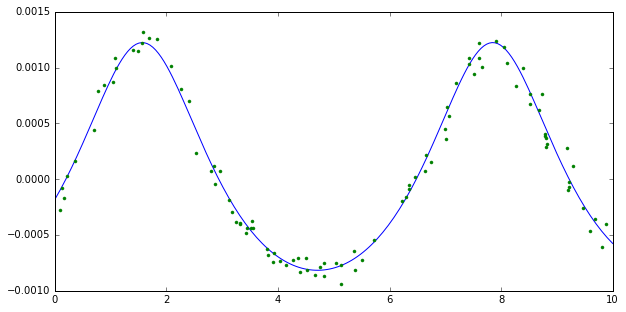

In [3]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(*true_state.get_rv_plotting(tmax=10.))
ax.plot(obs.t, obs.rv, ".")

# PalEns 
Starting from exact solution.

In [31]:
Nwalkers = 40
k = 20.
clip = 25
palens = mcmc.PalEns(true_state,obs,scales={"m":k*1e-3, "a":k*1., "h":k*0.5, "k":k*0.5, "l":k*np.pi},nwalkers=Nwalkers)
Niter = 100
chain = np.zeros((Niter,Nwalkers,palens.state.Nvars))
chainlogp = np.zeros((Niter,Nwalkers))
tries = 0
for i in range(Niter):
    tries += palens.step_force(pool=pool)
    for k in range(Nwalkers):
        chain[i][k] = palens.states[k].values
        chainlogp[i][k] = palens.states[k].logp
    clear_output(" "); 
    print("%d/%d"%(i+1,Niter))
    if i%clip==0 and i>0:
        print("throwing away worst offenders")
        logpm = np.median(chainlogp[i,:])
        for k in range(Nwalkers):
            if palens.states[k].logp<logpm:
                while True:
                    j = np.random.randint(Nwalkers)
                    if j!=k and palens.states[j].logp>logpm:
                        palens.states[k] = palens.states[j].deepcopy()
                        palens.states[k].logp = palens.states[j].logp
                        break
            
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

100/100
Acceptance rate: 52.83%
time: 1min 31s


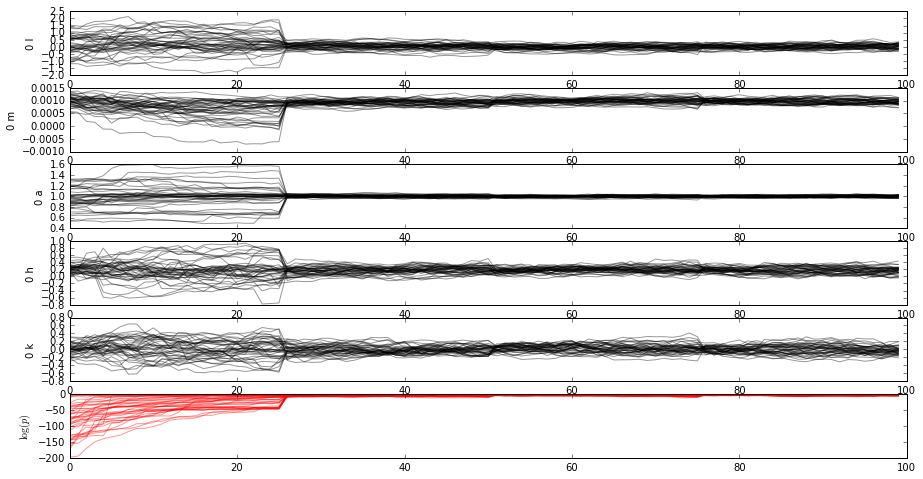

time: 1.91 s


In [32]:
f, axs = plt.subplots(true_state.Nvars+1,1,figsize=(15,8))
for i in range(true_state.Nvars):
    for k in range(Nwalkers):
        ax = axs[i]
        ax.set_ylabel(true_state.keys[i])
        ax.plot(chain[:,k,i], color="black",alpha=0.4)
for k in range(Nwalkers):
    ax = axs[true_state.Nvars]
    ax.set_ylabel("$\log(p)$")
    ax.plot(chainlogp[:,k], color="red",alpha=0.4)    

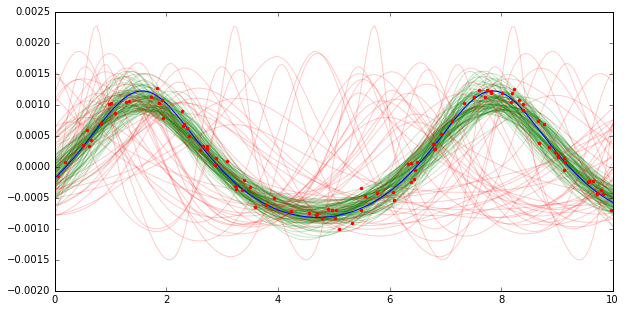

time: 1.49 s


In [35]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for l in range(100):
    i = np.random.randint(clip,Niter)
    k = np.random.randint(Nwalkers)
    s = palens.state.deepcopy()
    s.values = chain[i,k]
    color="green"
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.2, color=color)
for k in range(Nwalkers):
    s = palens.state.deepcopy()
    s.values = chain[0,k]
    color="red"
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.2, color=color)
    
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

/Users/rein/git/rebound/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/rein/git/rebound/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


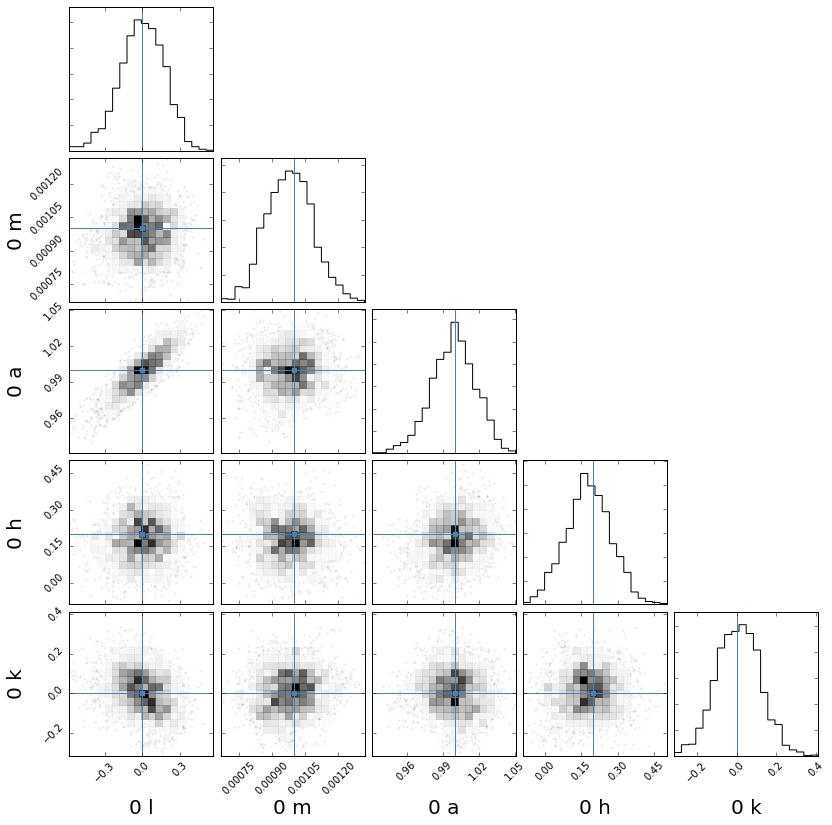

time: 3.01 s


In [37]:
figure = corner.corner(np.reshape(chain[clip*2:],(Nwalkers*(Niter-clip*2),true_state.Nvars)), labels=s.keys, plot_contours=False, truths=true_state.values,label_kwargs={"fontsize":20})